### RDD - Resilient Distributed Dataset
<font size ="2"> 
RDD is akin to the data frame, but it distributes unordered objects rather than records and column.

This object-first approach provides more flexibility compared to the more rigid schema of data frames.

The RDD especially shines in two use cases:

- When you have an unordered collection of Python objects that can be pickled.
- When you have unordered key, value pairs, and no fixed structure like in a Python dictionary.

</font>


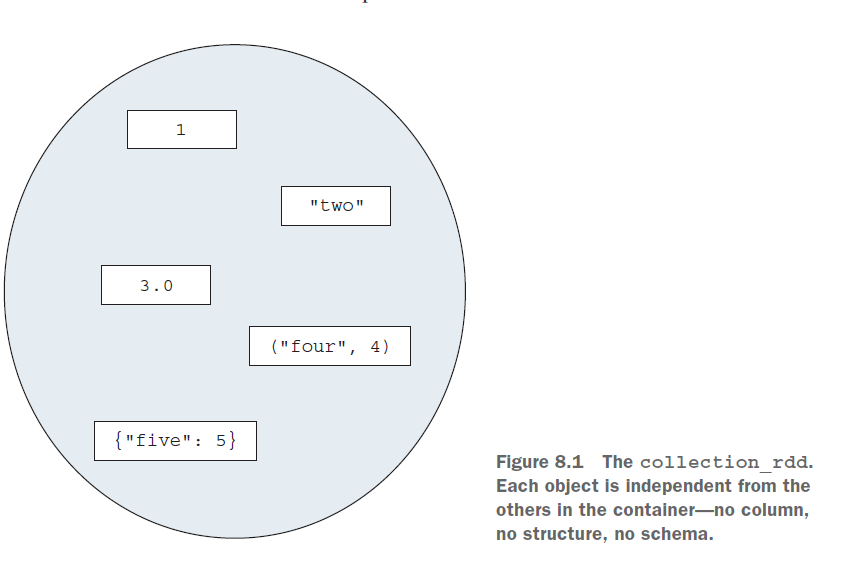

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
collection = [1, "two", 3.0, ("four", 4), {"five": 5}]

# The RDD functions and methods are under the SparkContext object, accessible as an attribute of our SparkSession. I alias it to sc for convenience.
sc = spark.sparkContext

collection_rdd = sc.parallelize(collection) # The list gets promoted to an RDD using the parallelize method of the SparkContext
print(collection_rdd)

23/11/02 05:03:21 WARN Utils: Your hostname, LAPTOP-JR3B3TTQ resolves to a loopback address: 127.0.1.1; using 172.28.169.28 instead (on interface eth0)
23/11/02 05:03:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/02 05:03:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/02 05:03:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/02 05:03:26 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289


### APPLY ONE FUNCTION TO EVERY OBJECT: MAP

In [2]:

from py4j.protocol import Py4JJavaError

def add_one(value):
    return value + 1

collection_rdd = collection_rdd.map(add_one)
try:
    print(collection_rdd.collect()) #collect() materializes an RDD into a Python list on the master node.
except Py4JJavaError:
    pass

23/11/02 05:03:30 ERROR Executor: Exception in task 7.0 in stage 0.0 (TID 7)/ 8]
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_78621/4206410748.py", line 4, in add_one
TypeError: unsupported operand type(s) for +: 'dict' and 'int'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(P

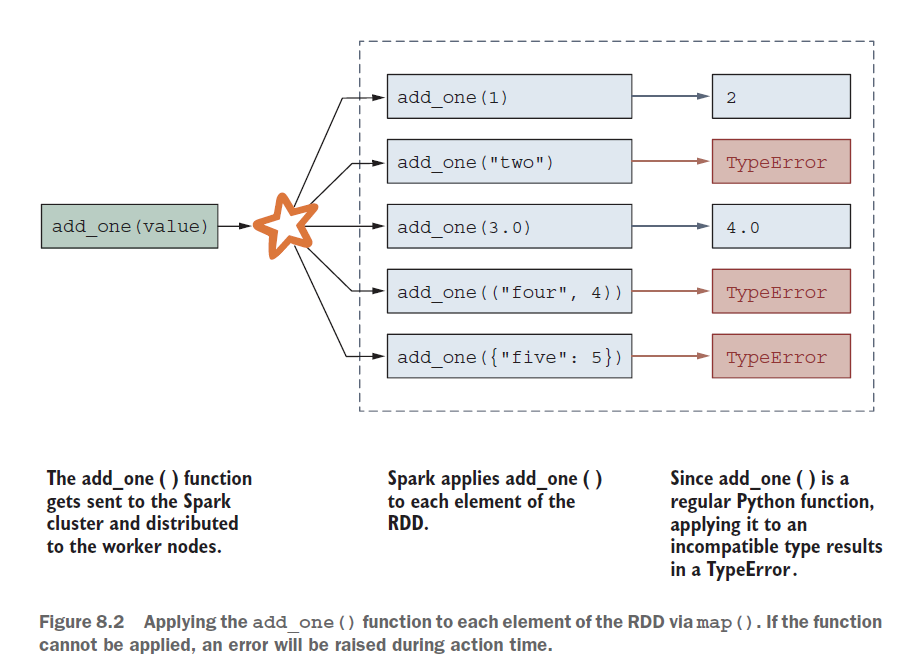

In [3]:
collection_rdd = sc.parallelize(collection)
def safer_add_one(value):
    # Error Handling
    try:
        return value + 1
    except TypeError: 
        return value

collection_rdd = collection_rdd.map(safer_add_one)
print(collection_rdd.collect())


[2, 'two', 4.0, ('four', 4), {'five': 5}]


### ONLY KEEP WHAT YOU WANT USING FILTER

In [4]:
collection_rdd = collection_rdd.filter(
    lambda elem: isinstance(elem, (float, int))
)
print(collection_rdd.collect())

[2, 4.0]


### TWO ELEMENTS COME IN, ONE COMES OUT: REDUCE()

In [5]:
from operator import add
collection_rdd = sc.parallelize([4, 7, 9, 1, 3])
print(collection_rdd.reduce(add))

24


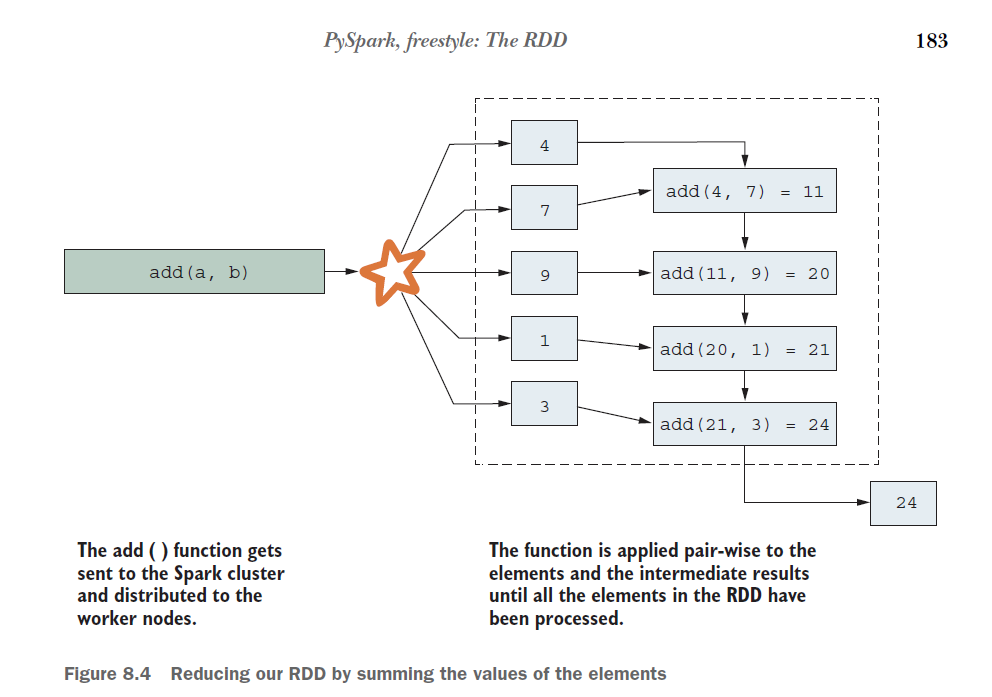

### UDFs - User Defined Functions

A User Defined Function is a custom function defined to perform transformation operations on Pyspark dataframes.

In [14]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from fractions import Fraction
from typing import Tuple, Optional
Frac = Tuple[int, int]

fractions = [[x, y] for x in range(100) for y in range(1, 100)]
frac_df = spark.createDataFrame(fractions, ["numerator", "denominator"])
frac_df = frac_df.select(
    F.array(F.col("numerator"), F.col("denominator")).alias("fraction"),
)

frac_df.show(5)

def py_reduce_fraction(frac: Frac) -> Optional[Frac]:
    """Reduce a fraction represented as a 2-tuple of integers."""
    num, denom = frac
    if denom:
        answer = Fraction(num, denom)
        return answer.numerator, answer.denominator
    return None

def py_fraction_to_float(frac: Frac) -> Optional[float]:
    """Transforms a fraction represented as a 2-tuple of integers into a float."""
    num, denom = frac
    if denom:
        return num / denom
    return None

+--------+
|fraction|
+--------+
|  [0, 1]|
|  [0, 2]|
|  [0, 3]|
|  [0, 4]|
|  [0, 5]|
+--------+
only showing top 5 rows



### Promoting Python function to UDF

In [15]:

SparkFrac = T.ArrayType(T.LongType()) #Array of LongType PySpark Variables in result type element wise

#The function takes two parameters:
# - The function you want to promote
# - The return type of the generated UDF
reduce_fraction = F.udf(py_reduce_fraction, SparkFrac)

frac_df = frac_df.withColumn(
"reduced_fraction", reduce_fraction(F.col("fraction"))
)

frac_df.show(200, False)

+--------+----------------+
|fraction|reduced_fraction|
+--------+----------------+
|[0, 1]  |[0, 1]          |
|[0, 2]  |[0, 1]          |
|[0, 3]  |[0, 1]          |
|[0, 4]  |[0, 1]          |
|[0, 5]  |[0, 1]          |
|[0, 6]  |[0, 1]          |
|[0, 7]  |[0, 1]          |
|[0, 8]  |[0, 1]          |
|[0, 9]  |[0, 1]          |
|[0, 10] |[0, 1]          |
|[0, 11] |[0, 1]          |
|[0, 12] |[0, 1]          |
|[0, 13] |[0, 1]          |
|[0, 14] |[0, 1]          |
|[0, 15] |[0, 1]          |
|[0, 16] |[0, 1]          |
|[0, 17] |[0, 1]          |
|[0, 18] |[0, 1]          |
|[0, 19] |[0, 1]          |
|[0, 20] |[0, 1]          |
|[0, 21] |[0, 1]          |
|[0, 22] |[0, 1]          |
|[0, 23] |[0, 1]          |
|[0, 24] |[0, 1]          |
|[0, 25] |[0, 1]          |
|[0, 26] |[0, 1]          |
|[0, 27] |[0, 1]          |
|[0, 28] |[0, 1]          |
|[0, 29] |[0, 1]          |
|[0, 30] |[0, 1]          |
|[0, 31] |[0, 1]          |
|[0, 32] |[0, 1]          |
|[0, 33] |[0, 1]    

### Creating a UDF directly using the udf() decorator

In [18]:
#Decorator is used here 
#Decorators are functions applied to other functions

#Element's Return Type when processed with udf functions
@F.udf(T.ArrayType(T.LongType()))  #This needs to be PySpark Types

def py_reduce_fraction(frac: Frac) -> Optional[Frac]: #Overall Functions Return Type which is Python Datatypes
    """Reduce a fraction represented as a 2-tuple of integers."""
    num, denom = frac
    if denom:
        answer = Fraction(num, denom)
        return answer.numerator, answer.denominator
    return None

frac_df = frac_df.withColumn(
"reduced_fraction", reduce_fraction(F.col("fraction"))
)

frac_df.show(5)

+--------+----------------+
|fraction|reduced_fraction|
+--------+----------------+
|  [0, 1]|          [0, 1]|
|  [0, 2]|          [0, 1]|
|  [0, 3]|          [0, 1]|
|  [0, 4]|          [0, 1]|
|  [0, 5]|          [0, 1]|
+--------+----------------+
only showing top 5 rows



In [19]:
@F.udf(T.DoubleType())
def fraction_to_float(frac: Frac) -> Optional[float]:
    """Transforms a fraction represented as a 2-tuple of integers into a float."""
    num, denom = frac
    if denom:
        return num / denom
    return None

frac_df = frac_df.withColumn("fraction_float", fraction_to_float(F.col("reduced_fraction")))

frac_df.select("reduced_fraction", "fraction_float").distinct().show(5, False)
    

+----------------+-------------------+
|reduced_fraction|fraction_float     |
+----------------+-------------------+
|[3, 50]         |0.06               |
|[3, 67]         |0.04477611940298507|
|[7, 76]         |0.09210526315789473|
|[9, 23]         |0.391304347826087  |
|[9, 25]         |0.36               |
+----------------+-------------------+
only showing top 5 rows

